In [1]:
import sys
import copy

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch

from utils.options import args_parser
from utils.utils import exp_details, get_train_test, get_model
from utils.update import LocalUpdate
from utils.sampling import dominant_label_sampling, dirichlet_sampling

In [2]:
args = args_parser(default=True)

args.local_ep = 5
args.lr = 0.00001
args.supervision = True

exp_details(args)


Experimental details:

Reinforcement Arguments:
    Steps Before PPO Update : 256
    PPO Learning Rate       : 0.0003
    PPO Discount Factor     : 0.9
    PPO Batch Size          : 16
    PPO Total Timesteps     : 15000
    Target Accuracy         : 0.95

Federated Arguments:
    Number of Users         : 100
    Fraction of Users       : 0.1
    Local Epochs            : 5
    Local Batch Size        : 10
    Learning Rate           : 1e-05
    Momentum                : 0.5
    Optimizer               : adam

Model Arguments:
    Supervision             : True
    Architecture            : cnn

Misc. Arguments:
    Dataset                 : mnist
    Number of GPUs          : 1
    IID                     : 0
    Random Seed             : 1
    Test Fraction           : 1
    Save Path               : ../../save
    Data Path               : ../../data



In [82]:
def train_local_models(dataset, arch, sampling_type, save_layers=None):
    train_dataset, _ = get_train_test(dataset)

    base_model = get_model(arch, dataset, "cuda")
    local_models = [copy.deepcopy(base_model) for _ in range(args.num_users)]

    if sampling_type == "dominant_label":
        dict_users = dominant_label_sampling(train_dataset, num_users=args.num_users, num_samples=50_000, gamma=0.8, print_labels=False)
    if sampling_type == "dirichlet":
        dict_users = dirichlet_sampling(train_dataset, num_users=args.num_users, num_samples=30_000, alpha=0.2, print_labels=False)

    print("Training client fitting models...")
    user_params = []
    user_labels = []
    for i, user_samples in tqdm(dict_users.items()):
        local_model = local_models[i]
        local_update = LocalUpdate(
            train_dataset,
            user_samples,
            args.local_ep,
            args.local_bs,
            args.lr,
            args.optimizer,
            args.supervision,
            "cuda",
        )
        local_update.update_weights(local_model)
        
        if save_layers is None:
            params = torch.cat([p.flatten() for p in local_model.parameters()]).detach().cpu().numpy()
        else:
            params = []
            for layer in save_layers:
                layer_params = local_model.__dict__["_modules"][layer].parameters()
                layer_params_flat = torch.cat([p.flatten() for p in layer_params]).detach().cpu().numpy()
                params.append(layer_params_flat)
        
        labels = np.array(train_dataset.targets)[list(user_samples)]
        user_params.append(params)
        user_labels.append(labels)

    return user_params, user_labels


def plot_pca(dataset, sampling_type, user_params, user_labels, layer=None):
    if dataset == "mnist":
        dataset_name = "MNIST"
        label_names = np.array([str(i) for i in range(10)])
    elif dataset == "cifar":
        dataset_name = "CIFAR-10"
        label_names = np.array(["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
        
    if sampling_type == "dirichlet":
        sampling_type_name = "Dirichlet"
    elif sampling_type == "dominant_label":
        sampling_type_name = "80%-20%"
        
    user_params_pca = PCA(n_components=2).fit_transform(user_params)
    dominant_label_idxs = [stats.mode(labels).mode[0] for labels in user_labels]
    dominant_label_names = label_names[dominant_label_idxs]
    dominant_label_ratios = np.array([stats.mode(labels).count[0] / len(labels) for labels in user_labels])
    
    # rescale dominant label ratios
    if sampling_type == "dirichlet":
        min_ratio = min(dominant_label_ratios)
        max_ratio = max(dominant_label_ratios)
        dominant_label_ratios = (dominant_label_ratios - min_ratio) / max_ratio
        dominant_label_ratios *= 150
    else:
        dominant_label_ratios *= 80
    
    colors = np.array(sns.color_palette("tab10"))
    
    df = pd.DataFrame({"Principal Component 1": user_params_pca[:, 0], "Principal Component 2": user_params_pca[:, 1]})
    
    for i, (params_pca, labels) in enumerate(zip(user_params_pca, user_labels)):
        mode = stats.mode(labels)
        dominant_label, dominant_label_ratio = mode.mode[0], mode.count[0] / len(labels)
        
    ax = sns.scatterplot(data=df, x="Principal Component 1", y="Principal Component 2", c=colors[dominant_label_idxs], s=dominant_label_ratios, linewidth=0)
    ax.set_title(f"{dataset_name} Client Models, {sampling_type_name} Sampling{'' if layer is None else ', ' + layer}")
    handles = []
    for label, color in zip(label_names, colors):
        patch = matplotlib.patches.Patch(color=color, label=label)
        handles.append(patch)

    plt.legend(handles=handles, bbox_to_anchor=(1, 1))

Training client fitting models...


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


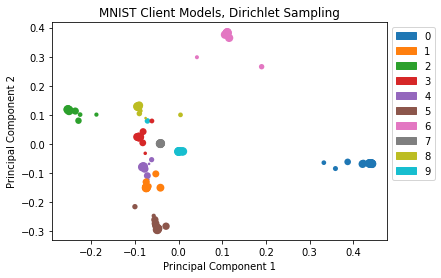

In [299]:
user_params, user_labels = train_local_models("mnist", "mlp", "dirichlet")
plot_pca("mnist", "dirichlet", user_params, user_labels)

In [7]:
user_params, user_labels = train_local_models("cifar", "cnn", "dirichlet")
plot_pca("cifar", "dirichlet", user_params, user_labels)

Training client fitting models...


 15%|█▌        | 15/100 [00:06<00:36,  2.33it/s]


KeyboardInterrupt: 

Training client fitting models...


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


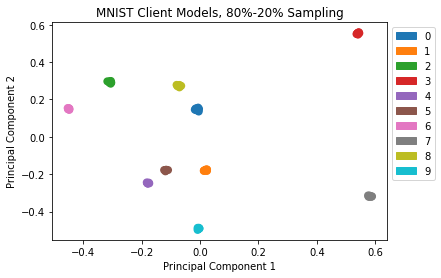

In [8]:
user_params, user_labels = train_local_models("mnist", "mlp", "dominant_label")
plot_pca("mnist", "dominant_label", user_params, user_labels)

Training client fitting models...


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


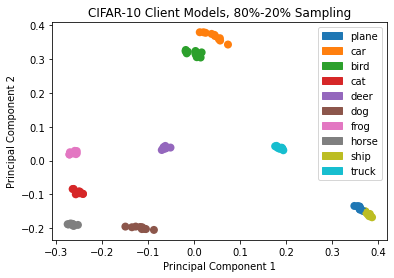

In [9]:
user_params, user_labels = train_local_models("cifar", "cnn", "dominant_label")
plot_pca("cifar", "dominant_label", user_params, user_labels)

In [71]:
user_params, user_labels = train_local_models("cifar", "cnn", "dominant_label", save_layers=["conv1", "conv2", "conv3", "fc1", "fc2"])

Training client fitting models...


100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


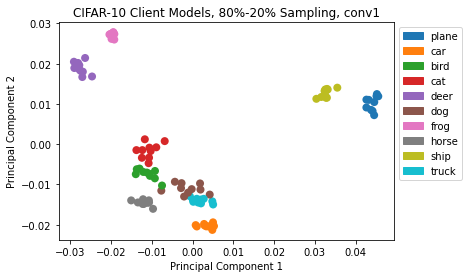

In [83]:
conv1_params = [param[0] for param in user_params]
plot_pca("cifar", "dominant_label", conv1_params, user_labels, "conv1")

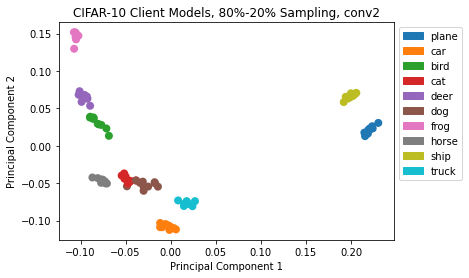

In [84]:
conv2_params = [param[1] for param in user_params]
plot_pca("cifar", "dominant_label", conv2_params, user_labels, "conv2")

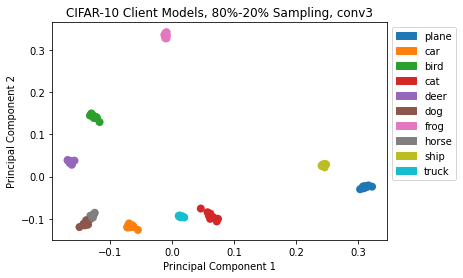

In [85]:
conv3_params = [param[2] for param in user_params]
plot_pca("cifar", "dominant_label", conv3_params, user_labels, "conv3")

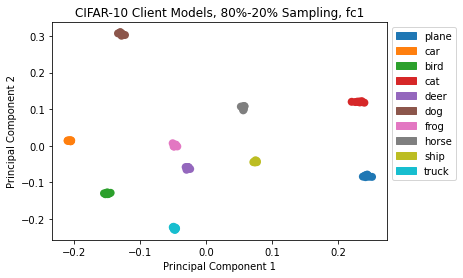

In [86]:
fc1_params = [param[3] for param in user_params]
plot_pca("cifar", "dominant_label", fc1_params, user_labels, "fc1")

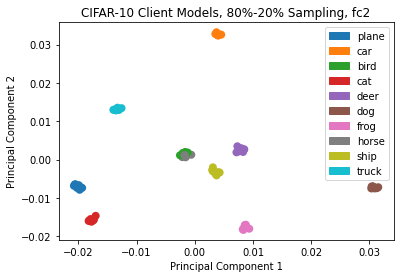

In [87]:
fc2_params = [param[4] for param in user_params]
plot_pca("cifar", "dominant_label", fc2_params, user_labels, "fc2")